# Tests

## 01. Get the Fashion-MNIST

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the Fashion-MNIST dataset, with the train and test inputs and outputs
(train_inputs, train_outputs), (test_inputs, test_outputs) = tf.keras.datasets.fashion_mnist.load_data()

# Translate the train and test outputs into labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_labels = [class_labels[i] for i in train_outputs]
test_labels = [class_labels[i] for i in test_outputs]

train_inputs = train_inputs/255.0
test_inputs = test_inputs/255.0

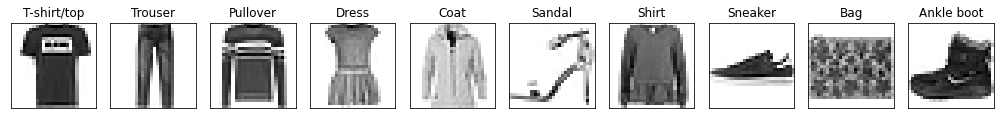

In [20]:
# Show a single example for the different classes
number_classes = len(class_labels)
plt.figure(figsize=(14, 2))
for i in range(number_classes):
    j = np.where(train_outputs==i)[0][0]
    plt.subplot(1, number_classes, i+1)
    plt.imshow(train_inputs[j, :, :], cmap="binary")
    plt.xticks([])
    plt.yticks([])
    plt.title(class_labels[i])
    plt.tight_layout()
plt.show()

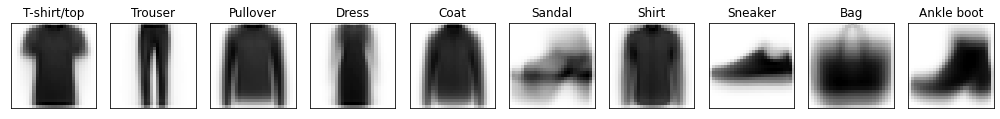

In [21]:
# Show the mean for the different classes
number_classes = len(class_labels)
plt.figure(figsize=(14, 2))
for i in range(number_classes):
    j = train_outputs == i
    plt.subplot(1, number_classes, i+1)
    plt.imshow(np.mean(train_inputs[j, :, :], 0), cmap="binary")
    plt.xticks([])
    plt.yticks([])
    plt.title(class_labels[i])
    plt.tight_layout()
plt.show()

## 02. Create a Simple Model

In [22]:
# Build the model (with one input layer flattened, one hidden layer dense, and one output layer dense)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=np.shape(train_inputs)[1:3]),
    tf.keras.layers.Dense(128, 
                          activation="relu", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                          bias_initializer='zeros'),
    tf.keras.layers.Dense(10, 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                          bias_initializer='zeros')
])

# Compile the model (with gradient descent optimizer)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_inputs, train_outputs, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 1s 524us/step - loss: 0.8536 - accuracy: 0.6912
Epoch 2/10
1875/1875 [==============================] - 1s 548us/step - loss: 0.4217 - accuracy: 0.8462
Epoch 3/10
1875/1875 [==============================] - 1s 533us/step - loss: 0.3769 - accuracy: 0.8615
Epoch 4/10
1875/1875 [==============================] - 1s 554us/step - loss: 0.3460 - accuracy: 0.8729
Epoch 5/10
1875/1875 [==============================] - 1s 541us/step - loss: 0.3254 - accuracy: 0.8790
Epoch 6/10
1875/1875 [==============================] - 1s 561us/step - loss: 0.3187 - accuracy: 0.8823
Epoch 7/10
1875/1875 [==============================] - 1s 604us/step - loss: 0.3005 - accuracy: 0.8910
Epoch 8/10
1875/1875 [==============================] - 1s 631us/step - loss: 0.2905 - accuracy: 0.8919
Epoch 9/10
1875/1875 [==============================] - 1s 545us/step - loss: 0.2791 - accuracy: 0.8974
Epoch 10/10
1875/1875 [==============================] - 1s 595u

# 01. Single neuron and linear regression

## 01.1 Create a function (single linear neuron) with some inputs and outputs

In [48]:
%reset

import numpy as np

# Define the true weights and bias for a single linear neuron
# (see also http://d2l.ai/chapter_linear-networks/linear-regression-scratch.html)
true_weights = np.array([2, -3.4])
true_bias = 4.2

# Create some inputs using a standard normal distribution
number_examples = 1000
number_features = len(true_weights)
true_inputs = np.random.normal(loc=0.0, scale=1.0, size=(number_examples, number_features))

# Create some noise for all the examples using a normal distribution
true_noise = np.random.normal(loc=0.0, scale=0.01, size=number_examples)
    
# Compute the true outputs using the inputs, and the true weights, bias, and noise
true_outputs = np.matmul(true_inputs, true_weights) + true_bias + true_noise

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 01.2. Learn the parameters of the neuron using gradient descent

In [49]:
# Define the training parameters
number_epochs = 10
batch_size = 10
learning_rate = 0.03

# Initialize the predicted weights and bias
predicted_weights = np.random.normal(loc=0.0, scale=0.01, size=number_features)
predicted_bias = 0

# Initialize the loss for all the batches
number_batches = int(np.ceil(number_examples/batch_size))
predicted_loss = np.zeros(number_batches)

# Loop over the epochs
for i in range(number_epochs):
    
    # Loop over the batches
    k = 0
    for j in range(0, number_examples, batch_size):
        
        # Derive the end index of the batch
        j2 = min(j+batch_size, number_examples)
    
        # Compute the predicted outputs using the inputs, and the predicted weights and bias
        predicted_outputs = np.matmul(true_inputs[j:j2, :], predicted_weights) + predicted_bias

        # Compute the difference between the predicted outputs and the true outputs
        output_differences = predicted_outputs-true_outputs[j:j2]

        # Compute the loss using the mean squared error
        predicted_loss[k] = np.mean(0.5*np.power(output_differences, 2))
        
        # Do not need to make the last updates after computing the last loss
        if i < number_epochs-1 or k < number_batches-1:
            
            # Update the predicted weights and bias using gradient descent, with the derivative of the loss function
            predicted_weights -= learning_rate*np.mean(true_inputs[j:j2, :]*(output_differences)[:, np.newaxis], axis=0)
            predicted_bias -= learning_rate*np.mean(output_differences, axis=0)
            
        # Update the index
        k = k+1
    
    # Print the epoch and loss
    print(f"Epoch: {i}; loss: {np.mean(predicted_loss)}")
    
# Print the predicted weights and bias
print("")
print(f"Predicted weights: {predicted_weights}")
print(f"Predicted bias: {predicted_bias}")

Epoch: 0; loss: 2.8178068093399515
Epoch: 1; loss: 0.008657554420596639
Epoch: 2; loss: 7.830017943958494e-05
Epoch: 3; loss: 5.141891440363032e-05
Epoch: 4; loss: 5.1363440814342625e-05
Epoch: 5; loss: 5.1365079908663894e-05
Epoch: 6; loss: 5.136518882777341e-05
Epoch: 7; loss: 5.136519515922528e-05
Epoch: 8; loss: 5.136519552823079e-05
Epoch: 9; loss: 5.1365195549856344e-05

Predicted weights: [ 1.99999494 -3.40075876]
Predicted bias: 4.200677829374865


## 01.3. Learn the parameters of the neuron using gradient descent in Keras

In [3]:
import tensorflow as tf

# Define the training parameters
number_epochs = 10
batch_size = 10
learning_rate = 0.03

# Initialize the model (as a feedforward NN)
model = tf.keras.Sequential()

# Add an input with the number of features
model.add(tf.keras.Input(shape=number_features))

# Add a densely-connected NN layer without activation and with initialized weights and bias
model.add(tf.keras.layers.Dense(1, activation=None, \
                                kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01), \
                                bias_initializer="zeros"))

# Configure the model for training with gradient descent optimizer and mean squared error loss
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss="mean_squared_error")

# Train the model give the batch size and number of epochs
model.fit(x=true_inputs, y=true_outputs, batch_size=batch_size, epochs=number_epochs, verbose=1)

# Print the predicted weights and bias
print("")
print(f"Predicted weights: {model.get_weights()[0][:, 0]}")
print(f"Predicted bias: {model.get_weights()[1][0]}")

Epoch 1/10
100/100 [==============================] - 0s 354us/step - loss: 8.5697
Epoch 2/10
100/100 [==============================] - 0s 343us/step - loss: 1.5144e-04
Epoch 3/10
100/100 [==============================] - 0s 354us/step - loss: 1.0111e-04
Epoch 4/10
100/100 [==============================] - 0s 354us/step - loss: 9.9907e-05
Epoch 5/10
100/100 [==============================] - 0s 374us/step - loss: 9.6224e-05
Epoch 6/10
100/100 [==============================] - 0s 343us/step - loss: 9.2783e-05
Epoch 7/10
100/100 [==============================] - 0s 343us/step - loss: 1.0346e-04
Epoch 8/10
100/100 [==============================] - 0s 343us/step - loss: 1.0498e-04
Epoch 9/10
100/100 [==============================] - 0s 343us/step - loss: 9.9771e-05
Epoch 10/10
100/100 [==============================] - 0s 354us/step - loss: 9.7006e-05

Predicted weights: [ 1.9996102 -3.3997617]
Predicted bias: 4.199385166168213


## 01.4. Learn the parameters of the neuron using an evolutionary algorithm

In [4]:
# Define the training parameters
number_epochs = 10
batch_size = 10
number_individuals = 10
number_parents = 2
mutation_rate = 0.01

# Initialize the predicted weights and bias for all the individuals
predicted_weights = np.random.normal(loc=0.0, scale=0.01, size=(number_features, number_individuals))
predicted_bias = np.zeros((1, number_individuals))

# Initialize the loss for all the batches and for all the individuals
number_batches = int(np.ceil(number_examples/batch_size))
predicted_loss = np.zeros((number_batches, number_individuals))

# Loop over the epochs
for i in range(number_epochs):
    
    # Loop over the batches
    k = 0
    for j in range(0, number_examples, batch_size):
        
        # Derive the end index of the batch
        j2 = min(j+batch_size, number_examples)
    
        # Compute the predicted outputs using the inputs, and the predicted weights and bias, for every individual
        predicted_outputs = np.matmul(true_inputs[j:j2, :], predicted_weights) + predicted_bias

        # Compute the loss using the mean squared error, for every individual
        predicted_loss[k, :] = np.mean(np.power(predicted_outputs-true_outputs[j:j2, np.newaxis], 2), axis=0)
        
        # Do not need to make the last updates after computing the last loss
        if i < number_epochs-1 or k < number_batches-1:
        
            # Get the indices of the parents (the fittest individuals)
            parent_indices = np.argsort(predicted_loss[k, :])[0:number_parents]

            # Compute the mutation scale using the root mean square error
#             mutation_scale = mutation_rate*np.mean(np.sqrt(predicted_loss[k, parent_indices]))
            mutation_scale = mutation_rate
            
            # Update the predicted weights and bias using evolutionary algorithm, doing crossover and mutation
            predicted_weights = np.mean(predicted_weights[:, parent_indices], axis=1)[:, np.newaxis] \
            + np.random.normal(loc=0.0, scale=mutation_scale, size=(number_features, number_individuals))
            predicted_bias = np.mean(predicted_bias[:, parent_indices]) \
            + np.random.normal(loc=0.0, scale=mutation_scale, size=(1, number_individuals))
        
        # Update the index
        k = k+1
        
    # Print the epoch and loss
    print(f"Epoch: {i}; loss: {np.mean(predicted_loss)}")
    
# Print the predicted weights and bias
print("")
print(f"Predicted weights: {np.mean(predicted_weights, axis=1)}")
print(f"Predicted bias: {np.mean(predicted_bias)}")

Epoch: 0; loss: 26.16919771857581
Epoch: 1; loss: 15.89573684352735
Epoch: 2; loss: 8.374283380005487
Epoch: 3; loss: 2.9675768340124478
Epoch: 4; loss: 0.38137886645304675
Epoch: 5; loss: 0.0005220220825590036
Epoch: 6; loss: 0.00048325837539071447
Epoch: 7; loss: 0.0005137403673791562
Epoch: 8; loss: 0.0005089096714666468
Epoch: 9; loss: 0.0004962522573057658

Predicted weights: [ 1.9938385 -3.4027235]
Predicted bias: 4.209371000895826


## 01.4.2. Learn the parameters of the neuron using a simpler evolutionary algorithm

In [5]:
# Define the training parameters
number_epochs = 10
batch_size = 10
mutation_scale = 0.01

# Initialize the predicted weights and bias
predicted_weights = np.random.normal(loc=0.0, scale=0.01, size=number_features)
predicted_bias = 0

# Initialize the loss for all the batches
number_batches = int(np.ceil(number_examples/batch_size))
predicted_loss = np.zeros(number_batches)

# Loop over the epochs
for i in range(number_epochs):
    
    # Loop over the batches
    k = 0
    for j in range(0, number_examples, batch_size):
        
        # Derive the end index of the batch
        j2 = min(j+batch_size, number_examples)
    
        # Compute the predicted outputs using the inputs, and the predicted weights and bias
        predicted_outputs = np.matmul(true_inputs[j:j2, :], predicted_weights) + predicted_bias
        
        # Compute the loss using the mean squared error
        predicted_loss[k] = np.mean(0.5*np.power(predicted_outputs-true_outputs[j:j2], 2))
        
        # Initialize the next loss
        predicted_loss2 = np.inf                    
        
        # While the next predicted loss is higher
        while predicted_loss2 >= predicted_loss[k]:
            
            # Mutate the weights and biases
            predicted_weights2 = predicted_weights + np.random.normal(loc=0.0, scale=mutation_scale, size=number_features)
            predicted_bias2 = predicted_bias + np.random.normal(loc=0.0, scale=mutation_scale, size=1)
            
            # Compute the new outputs and loss
            predicted_outputs2 = np.matmul(true_inputs[j:j2, :], predicted_weights2) + predicted_bias2
            predicted_loss2 = np.mean(0.5*np.power(predicted_outputs2-true_outputs[j:j2], 2))
            
        # Update the weights, biases, and loss
        predicted_weights = predicted_weights2
        predicted_bias = predicted_bias2
        predicted_loss[k] = predicted_loss2
        
        # Update the index
        k = k+1
    
    # Print the epoch and loss
    print(f"Epoch: {i}; loss: {np.mean(predicted_loss)}")
    
# Print the predicted weights and bias
print("")
print(f"Predicted weights: {predicted_weights}")
print(f"Predicted bias: {predicted_bias}")

Epoch: 0; loss: 14.065245619831437
Epoch: 1; loss: 10.475700426308524
Epoch: 2; loss: 7.542908621351353
Epoch: 3; loss: 5.159025379365726
Epoch: 4; loss: 3.122533523693872
Epoch: 5; loss: 1.5003200038468014
Epoch: 6; loss: 0.5791979401322016
Epoch: 7; loss: 0.09645098729289182
Epoch: 8; loss: 0.0001001751696473215
Epoch: 9; loss: 7.551244142200755e-05

Predicted weights: [ 2.00399397 -3.40051534]
Predicted bias: [4.20423564]


# 02. Single neuron and softmax regression

## 02.1. Prepare a dataset for a multiclass classification problem

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


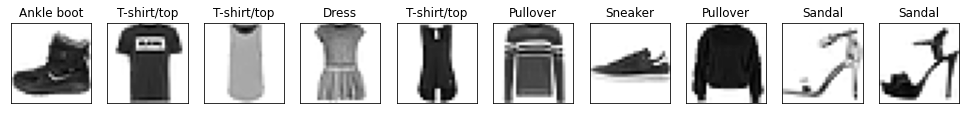

In [26]:
%reset

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Import the fashion-MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', \
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Show some of the data
plt.figure(figsize=(17, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

# Get the number of train and test examples and the sizes of the inputs and outputs
number_train = np.shape(train_images)[0]
number_test = np.shape(test_images)[0]
input_size = np.shape(train_images)[1]*np.shape(train_images)[2]
output_size = len(class_names)

# Reshape the inputs and normalize them
train_inputs = np.reshape(train_images, (number_train, input_size))
train_inputs = train_inputs/255
test_inputs = np.reshape(test_images, (number_test, input_size))
test_inputs = test_inputs/255

# Transform the outputs from label numbers to one-hot vectors
train_outputs = np.zeros((number_train, output_size))
for i in range(number_train):
    train_outputs[i, train_labels[i]] = 1
test_outputs = np.zeros((number_test, output_size))
for i in range(number_test):
    test_outputs[i, test_labels[i]] = 1

## 02.2. Learn the parameters of a neuron using gradient descent

In [41]:
# Define the training parameters
number_epochs = 10
batch_size = 256
learning_rate = 0.1

# Initialize the weights and biases
train_weights = np.random.normal(loc=0.0, scale=0.01, size=(input_size, output_size))
train_biases = np.zeros(output_size)

# Initialize the loss and the accuracy for all the batches
number_batches = int(np.ceil(number_train/batch_size))
train_loss = np.zeros(number_batches)
train_accuracy = np.zeros(number_batches)

# Loop over the epochs
for i in range(number_epochs):
    
    # Compute the predicted test outputs using the test inputs, and the learned weights and biases
    test_outputs2 = np.matmul(test_inputs, train_weights) + train_biases
    
    # Compute the conditional probabilities of each class using the softmax function
    # (modified to avoid numerical stability issues)
    test_outputs2 = test_outputs2-np.max(test_outputs2, axis=1)[:, np.newaxis]
    test_exp = np.exp(test_outputs2)
    test_softmax = test_exp/np.sum(test_exp, axis=1)[:, np.newaxis]
    
    # Compute the classification accuracy given the true test labels
    test_accuracy = np.mean(np.argmax(test_softmax, axis=1)==test_labels)
    
    # Loop over the batches
    k = 0
    for j in range(0, number_train, batch_size):
        
        # Derive the end index for the current batch
        j2 = min(j+batch_size, number_train)
    
        # Compute the predicted train outputs using the train inputs, and the learned weights and biases
        train_outputs2 = np.matmul(train_inputs[j:j2, :], train_weights) + train_biases
        
        # Compute the conditional probabilities of each class using the softmax function
        # (modified to avoid numerical stability issues)
        train_outputs2 = train_outputs2-np.max(train_outputs2, axis=1)[:, np.newaxis]
        train_exp = np.exp(train_outputs2)
        train_softmax = train_exp/np.sum(train_exp, axis=1)[:, np.newaxis]
        
        # Compute the cross-entropy loss given the true train outputs
        # (rewritten to avoid numerical stability issues)
#         train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]*np.log(train_softmax), axis=1))
        train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]\
                                        *(train_outputs2-np.log(np.sum(train_exp, axis=1)[:, np.newaxis])), axis=1))
        
        # Compute the classification accuracy given the true train labels
        train_accuracy[k] = np.mean(np.argmax(train_softmax, axis=1)==train_labels[j:j2])
        
        # Do not need to make the last updates after computing the last loss
        if i < number_epochs-1 or k < number_batches-1:
            
            # Compute the derivative of the loss wrt the output (logit before softmax)
            train_derivative = train_softmax-train_outputs[j:j2, :]
            
            # Get the real batch size
            batch_size2 = j2-j
            
            # Update the weights and biases using gradient descent
            train_weights = train_weights-learning_rate*np.matmul(train_inputs[j:j2, :].T, train_derivative)/batch_size2
            train_biases = train_biases-learning_rate*np.sum(train_derivative, axis=0)/batch_size2
            
        # Update the index
        k = k+1
        
    # Print the epoch and loss
    print(f"Epoch: {i}; train loss: {np.mean(train_loss)}; train accuracy: {np.mean(train_accuracy)}; test accuracy: {test_accuracy}")

Epoch: 0; train loss: 0.7839464409853965; train accuracy: 0.7499058067375886; test accuracy: 0.1351
Epoch: 1; train loss: 0.5700196939640748; train accuracy: 0.812638519503546; test accuracy: 0.7855
Epoch: 2; train loss: 0.5250399792070662; train accuracy: 0.8255984042553192; test accuracy: 0.811
Epoch: 3; train loss: 0.5009203389810575; train accuracy: 0.8316655585106383; test accuracy: 0.8194
Epoch: 4; train loss: 0.485130030500342; train accuracy: 0.8365359042553191; test accuracy: 0.8244
Epoch: 5; train loss: 0.47369480369247396; train accuracy: 0.84026484929078; test accuracy: 0.827
Epoch: 6; train loss: 0.46489115482651205; train accuracy: 0.8426750886524822; test accuracy: 0.8289
Epoch: 7; train loss: 0.4578281227460323; train accuracy: 0.844919104609929; test accuracy: 0.8323
Epoch: 8; train loss: 0.4519897178943545; train accuracy: 0.8466145833333333; test accuracy: 0.8332
Epoch: 9; train loss: 0.44705253709351034; train accuracy: 0.8478280141843971; test accuracy: 0.8343


## 02.3. Make predictions using the trained neuron

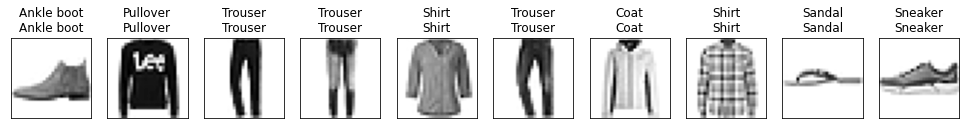

In [42]:
# Compute the predicted test outputs using the test inputs, and the learned weights and biases
test_outputs2 = np.matmul(test_inputs, train_weights) + train_biases

# Compute the conditional probabilities of each class using the softmax function
# (modified to avoid numerical stability issues)
test_outputs2 = test_outputs2-np.max(test_outputs2, axis=1)[:, np.newaxis]
test_exp = np.exp(test_outputs2)
test_softmax = test_exp/np.sum(test_exp, axis=1)[:, np.newaxis]

# Compute the predicted labels
test_labels2 = np.argmax(test_softmax, axis=1)

# Show the data with the true and predicted labels
plt.figure(figsize=(17, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.title(class_names[test_labels[i]] + "\n" + class_names[test_labels2[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

## 02.4. Learn the parameters of a neuron using gradient descent in Keras

In [4]:
import tensorflow as tf

# Define the training parameters
number_epochs = 10
batch_size = 256
learning_rate = 0.1

# Initialize the model (as a feedforward NN)
model = tf.keras.Sequential()

# Add an input with the number of features
model.add(tf.keras.Input(shape=input_size))

# Add a densely-connected NN layer without activation and with initialized weights and bias
model.add(tf.keras.layers.Dense(output_size, activation=None, \
                                kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01), \
                                bias_initializer="zeros"))

# Configure the model for training with gradient descent optimizer and cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), \
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), \
              metrics=["accuracy"])

# Train the model give the batch size and number of epochs
model.fit(x=train_inputs, y=train_outputs, batch_size=batch_size, epochs=number_epochs, verbose=1)

Epoch 1/10
235/235 [==============================] - 0s 786us/step - loss: 1.0260 - accuracy: 0.6745
Epoch 2/10
235/235 [==============================] - 0s 778us/step - loss: 0.5864 - accuracy: 0.8079
Epoch 3/10
235/235 [==============================] - 0s 765us/step - loss: 0.5351 - accuracy: 0.8228
Epoch 4/10
235/235 [==============================] - 0s 782us/step - loss: 0.5028 - accuracy: 0.8317
Epoch 5/10
235/235 [==============================] - 0s 799us/step - loss: 0.4893 - accuracy: 0.8365
Epoch 6/10
235/235 [==============================] - 0s 774us/step - loss: 0.4764 - accuracy: 0.8387
Epoch 7/10
235/235 [==============================] - 0s 782us/step - loss: 0.4682 - accuracy: 0.8408
Epoch 8/10
235/235 [==============================] - 0s 821us/step - loss: 0.4630 - accuracy: 0.8431
Epoch 9/10
235/235 [==============================] - 0s 765us/step - loss: 0.4537 - accuracy: 0.8467
Epoch 10/10
235/235 [==============================] - 0s 765us/step - loss: 0.440

## 02.5. Learn the parameters of a neuron using an EA

In [36]:
# Define the training parameters
number_epochs = 10
batch_size = 256
number_individuals = 10
number_parents = 2
mutation_rate = 0.01

# Initialize the weights and biases for all the individuals
train_weights = np.random.normal(loc=0.0, scale=0.01, size=(input_size, output_size, number_individuals))
train_biases = np.zeros((output_size, number_individuals))

# Initialize the loss and the accuracy for all the batches and for all the individuals
number_batches = int(np.ceil(number_train/batch_size))
train_loss = np.zeros((number_batches, number_individuals))
train_accuracy = np.zeros((number_batches, number_individuals))

# Loop over the epochs
for i in range(number_epochs):
    
    # Compute the predicted test outputs using the test inputs, and the learned weights and biases
    test_outputs2 = np.matmul(test_inputs, np.mean(train_weights, axis=2)) + np.mean(train_biases, axis=1)[np.newaxis, :]
    
    # Compute the conditional probabilities of each class using the softmax function
    # (modified to avoid numerical stability issues)
    test_outputs2 = test_outputs2-np.max(test_outputs2, axis=1)[:, np.newaxis]
    test_exp = np.exp(test_outputs2)
    test_softmax = test_exp/np.sum(test_exp, axis=1)[:, np.newaxis]
    
    # Compute the classification accuracy given the true test labels
    test_accuracy = np.mean(np.argmax(test_softmax, axis=1)==test_labels)
    
    # Loop over the batches
    k = 0
    for j in range(0, number_train, batch_size):
        
        # Derive the end index for the current batch
        j2 = min(j+batch_size, number_train)
    
        # Compute the predicted train outputs using the train inputs, and the learned weights and biases, for every individual
        train_outputs2 = np.tensordot(train_inputs[j:j2, :], train_weights, axes=(1,0)) + train_biases[np.newaxis, :, :]
        
        # Compute the conditional probabilities of each class using the softmax function
        # (modified to avoid numerical stability issues)
        train_outputs2 = train_outputs2-np.max(train_outputs2, axis=1)[:, np.newaxis, :]
        train_exp = np.exp(train_outputs2)
        train_softmax = train_exp/np.sum(train_exp, axis=1)[:, np.newaxis, :]
        
        # Compute the cross-entropy loss given the true train outputs
        # (rewritten to avoid numerical stability issues)
#         train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :, np.newaxis]*np.log(train_softmax), axis=1), axis=0)
        train_loss[k, :] = np.mean(-np.sum(train_outputs[j:j2, :, np.newaxis]\
                                        *(train_outputs2-np.log(np.sum(train_exp, axis=1)[:, np.newaxis, :])), axis=1), axis=0)
        
        # Compute the classification accuracy given the true train labels
        train_accuracy[k, :] = np.mean(np.argmax(train_softmax, axis=1) == train_labels[j:j2, np.newaxis], axis=0)
        
        # Do not need to make the last updates after computing the last loss
        if i < number_epochs-1 or k < number_batches-1:
            
            # Get the indices of the parents (the fittest individuals)
            parent_indices = np.argsort(train_loss[k, :])[0:number_parents]

            # Compute the mutation scale using the root mean square error
#             mutation_scale = 0.001*np.mean(np.sqrt(train_loss[k, parent_indices]))
            mutation_scale = mutation_rate
            
            # Update the weights and bias using EA, doing crossover and mutation
            train_weights = np.mean(train_weights[:, :, parent_indices], axis=2)[:, :, np.newaxis] \
            + np.random.normal(loc=0.0, scale=mutation_scale, size=(input_size, output_size, number_individuals))
            train_biases = np.mean(train_biases[:, parent_indices], axis=1)[:, np.newaxis] \
            + np.random.normal(loc=0.0, scale=mutation_scale, size=(output_size, number_individuals))
            
        # Update the index
        k = k+1
        
    # Print the epoch and loss
    print(f"Epoch: {i}; train loss: {np.mean(train_loss)}; train accuracy: {np.mean(train_accuracy)}; test accuracy: {test_accuracy}")

Epoch: 0; train loss: 1.4465094193881702; train accuracy: 0.5345279255319149; test accuracy: 0.07
Epoch: 1; train loss: 0.9218235883082819; train accuracy: 0.6845528590425531; test accuracy: 0.644
Epoch: 2; train loss: 0.8139263195166209; train accuracy: 0.7183649157801419; test accuracy: 0.7024
Epoch: 3; train loss: 0.760241497606201; train accuracy: 0.7354892508865248; test accuracy: 0.7257
Epoch: 4; train loss: 0.7459400614672582; train accuracy: 0.739726285460993; test accuracy: 0.7304
Epoch: 5; train loss: 0.7301011253673003; train accuracy: 0.7481776374113476; test accuracy: 0.7404
Epoch: 6; train loss: 0.7234255716094935; train accuracy: 0.752698359929078; test accuracy: 0.7444
Epoch: 7; train loss: 0.7211583417899639; train accuracy: 0.7531155806737588; test accuracy: 0.7407
Epoch: 8; train loss: 0.7126968935196831; train accuracy: 0.757130429964539; test accuracy: 0.749
Epoch: 9; train loss: 0.6986442258115251; train accuracy: 0.763071254432624; test accuracy: 0.7504


## 02.5.2. Learn the parameters of a neuron using a simpler EA

In [2]:
# Define the training parameters
number_epochs = 10
batch_size = 256
mutation_scale = 0.01

# Initialize the weights and biases
train_weights = np.random.normal(loc=0.0, scale=0.01, size=(input_size, output_size))
train_biases = np.zeros(output_size)

# Initialize the loss and the accuracy for all the batches
number_batches = int(np.ceil(number_train/batch_size))
train_loss = np.zeros(number_batches)
train_accuracy = np.zeros(number_batches)

# Loop over the epochs
for i in range(number_epochs):
    
    # Compute the predicted test outputs using the test inputs, and the learned weights and biases
    test_outputs2 = np.matmul(test_inputs, train_weights) + train_biases
    
    # Compute the conditional probabilities of each class using the softmax function
    # (modified to avoid numerical stability issues)
    test_outputs2 = test_outputs2-np.max(test_outputs2, axis=1)[:, np.newaxis]
    test_exp = np.exp(test_outputs2)
    test_softmax = test_exp/np.sum(test_exp, axis=1)[:, np.newaxis]
    
    # Compute the classification accuracy given the true test labels
    test_accuracy = np.mean(np.argmax(test_softmax, axis=1)==test_labels)
    
    # Loop over the batches
    k = 0
    for j in range(0, number_train, batch_size):
        
        # Derive the end index for the current batch
        j2 = min(j+batch_size, number_train)
    
        # Compute the predicted train outputs using the train inputs, and the learned weights and biases
        train_outputs2 = np.matmul(train_inputs[j:j2, :], train_weights) + train_biases
        
        # Compute the conditional probabilities of each class using the softmax function
        # (modified to avoid numerical stability issues)
        train_outputs2 = train_outputs2-np.max(train_outputs2, axis=1)[:, np.newaxis]
        train_exp = np.exp(train_outputs2)
        train_softmax = train_exp/np.sum(train_exp, axis=1)[:, np.newaxis]
        
        # Compute the cross-entropy loss given the true train outputs
        # (rewritten to avoid numerical stability issues)
#         train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]*np.log(train_softmax), axis=1))
        train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]\
                                        *(train_outputs2-np.log(np.sum(train_exp, axis=1)[:, np.newaxis])), axis=1))
        
        # Compute the classification accuracy given the true train labels
        train_accuracy[k] = np.mean(np.argmax(train_softmax, axis=1)==train_labels[j:j2])
        
        # Do not need to make the last updates after computing the last loss
        if i < number_epochs-1 or k < number_batches-1:
            
            # Initialize the next loss
            train_loss2 = np.inf
#             train_accuracy2 = -np.inf
            
            # While the next loss is higher
            while train_loss2 >= train_loss[k]:# or train_accuracy2 <= train_accuracy[k]:
                
                # Mutate the weights and biases
                train_weights2 = train_weights + np.random.normal(loc=0.0, scale=mutation_scale, size=(input_size, output_size))
                train_biases2 = train_biases + np.random.normal(loc=0.0, scale=mutation_scale, size=output_size)

                # Compute the new outputs and loss
                train_outputs2 = np.matmul(train_inputs[j:j2, :], train_weights2) + train_biases2
                train_outputs2 = train_outputs2-np.max(train_outputs2, axis=1)[:, np.newaxis]
                train_exp = np.exp(train_outputs2)
                train_softmax = train_exp/np.sum(train_exp, axis=1)[:, np.newaxis]
                train_loss2 = np.mean(-np.sum(train_outputs[j:j2, :]
                                              *(train_outputs2-np.log(np.sum(train_exp, axis=1)[:, np.newaxis])), axis=1))
                train_accuracy2 = np.mean(np.argmax(train_softmax, axis=1)==train_labels[j:j2])
                
            # Update the weights, biases, and loss
            train_weights = train_weights2
            train_biases = train_biases2
            train_loss[k] = train_loss2
            train_accuracy[k] = train_accuracy2
            
        # Update the index
        k = k+1
        
    # Print the epoch and loss
    print(f"Epoch: {i}; train loss: {np.mean(train_loss)}; train accuracy: {np.mean(train_accuracy)}; test accuracy: {test_accuracy}")

Epoch: 0; train loss: 1.6669687573807246; train accuracy: 0.40667664007092197; test accuracy: 0.1006
Epoch: 1; train loss: 1.0842577369341604; train accuracy: 0.6159242021276595; test accuracy: 0.5588
Epoch: 2; train loss: 0.971574929310999; train accuracy: 0.6558455230496455; test accuracy: 0.6419
Epoch: 3; train loss: 0.9513512098495406; train accuracy: 0.6691267730496455; test accuracy: 0.6501
Epoch: 4; train loss: 0.9715518269528978; train accuracy: 0.669143395390071; test accuracy: 0.6593
Epoch: 5; train loss: 0.9650695856565277; train accuracy: 0.6797595301418439; test accuracy: 0.6616
Epoch: 6; train loss: 0.9746718683890051; train accuracy: 0.686330895390071; test accuracy: 0.6762
Epoch: 7; train loss: 0.9905188469594617; train accuracy: 0.6892564273049646; test accuracy: 0.6739
Epoch: 8; train loss: 1.0133462676471632; train accuracy: 0.6878102836879434; test accuracy: 0.6816
Epoch: 9; train loss: 1.037961006505807; train accuracy: 0.6847573138297872; test accuracy: 0.686


In [27]:
# Define the training parameters
number_epochs = 10
batch_size = 256
mutation_scale = 0.01

# Initialize the weights and biases
train_weights = np.random.normal(loc=0.0, scale=0.01, size=(input_size, output_size))
train_biases = np.zeros(output_size)

# Initialize the loss and the accuracy for all the batches
number_batches = int(np.ceil(number_train/batch_size))
train_loss = np.zeros(number_batches)
train_accuracy = np.zeros(number_batches)

# Loop over the epochs
for i in range(number_epochs):
    
    # Compute the predicted test outputs using the test inputs, and the learned weights and biases
    test_outputs2 = np.abs(np.matmul(np.exp(1j*test_inputs), train_weights))
    
    # Compute the conditional probabilities of each class using the softmax function
    # (modified to avoid numerical stability issues)
    test_outputs2 = test_outputs2-np.max(test_outputs2, axis=1)[:, np.newaxis]
    test_exp = np.exp(test_outputs2)
    test_softmax = test_exp/np.sum(test_exp, axis=1)[:, np.newaxis]
    
    # Compute the classification accuracy given the true test labels
    test_accuracy = np.mean(np.argmax(test_softmax, axis=1)==test_labels)
    
    # Loop over the batches
    k = 0
    for j in range(0, number_train, batch_size):
        
        # Derive the end index for the current batch
        j2 = min(j+batch_size, number_train)
    
        # Compute the predicted train outputs using the train inputs, and the learned weights and biases
        train_outputs2 = np.abs(np.matmul(np.exp(1j*train_inputs[j:j2, :]), train_weights))
        
        # Compute the conditional probabilities of each class using the softmax function
        # (modified to avoid numerical stability issues)
        train_outputs2 = train_outputs2-np.max(train_outputs2, axis=1)[:, np.newaxis]
        train_exp = np.exp(train_outputs2)
        train_softmax = train_exp/np.sum(train_exp, axis=1)[:, np.newaxis]
        
        # Compute the cross-entropy loss given the true train outputs
        # (rewritten to avoid numerical stability issues)
#         train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]*np.log(train_softmax), axis=1))
        train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]\
                                        *(train_outputs2-np.log(np.sum(train_exp, axis=1)[:, np.newaxis])), axis=1))
        
        # Compute the classification accuracy given the true train labels
        train_accuracy[k] = np.mean(np.argmax(train_softmax, axis=1)==train_labels[j:j2])
        
        # Do not need to make the last updates after computing the last loss
        if i < number_epochs-1 or k < number_batches-1:
            
            # Initialize the next loss
            train_loss2 = np.inf
#             train_accuracy2 = -np.inf
            
            # While the next loss is higher
            while train_loss2 >= train_loss[k]:# or train_accuracy2 <= train_accuracy[k]:
                
                # Mutate the weights and biases
                train_weights2 = train_weights + np.random.normal(loc=0.0, scale=mutation_scale, size=(input_size, output_size))
                train_biases2 = train_biases + np.random.normal(loc=0.0, scale=mutation_scale, size=output_size)

                # Compute the new outputs and loss
                train_outputs2 = np.abs(np.matmul(np.exp(1j*train_inputs[j:j2, :]), train_weights2))
                train_outputs2 = train_outputs2-np.max(train_outputs2, axis=1)[:, np.newaxis]
                train_exp = np.exp(train_outputs2)
                train_softmax = train_exp/np.sum(train_exp, axis=1)[:, np.newaxis]
                train_loss2 = np.mean(-np.sum(train_outputs[j:j2, :]
                                              *(train_outputs2-np.log(np.sum(train_exp, axis=1)[:, np.newaxis])), axis=1))
                train_accuracy2 = np.mean(np.argmax(train_softmax, axis=1)==train_labels[j:j2])
                
            # Update the weights, biases, and loss
            train_weights = train_weights2
            train_biases = train_biases2
            train_loss[k] = train_loss2
            train_accuracy[k] = train_accuracy2
            
        # Update the index
        k = k+1
        
    # Print the epoch and loss
    print(f"Epoch: {i}; train loss: {np.mean(train_loss)}; train accuracy: {np.mean(train_accuracy)}; test accuracy: {test_accuracy}")

Epoch: 0; train loss: 1.7634195170627998; train accuracy: 0.41661125886524825; test accuracy: 0.0916
Epoch: 1; train loss: 1.288412248325961; train accuracy: 0.5723902925531915; test accuracy: 0.5208
Epoch: 2; train loss: 1.200681865497294; train accuracy: 0.5866522606382979; test accuracy: 0.5764
Epoch: 3; train loss: 1.122752511850418; train accuracy: 0.6064328457446808; test accuracy: 0.5973
Epoch: 4; train loss: 1.0488568181761198; train accuracy: 0.6330119680851064; test accuracy: 0.6292
Epoch: 5; train loss: 1.0551204453997955; train accuracy: 0.6371343085106383; test accuracy: 0.6263
Epoch: 6; train loss: 1.0697812671882696; train accuracy: 0.6366411790780141; test accuracy: 0.6266
Epoch: 7; train loss: 1.0692936227385574; train accuracy: 0.6462267287234043; test accuracy: 0.6312
Epoch: 8; train loss: 1.1112416861381438; train accuracy: 0.6322972074468085; test accuracy: 0.638
Epoch: 9; train loss: 1.132778405957056; train accuracy: 0.6260527482269502; test accuracy: 0.6185


# 03. Multilayer Perceptrons (MLP)

## 03.1. Prepare the dataset

In [21]:
%reset

import numpy as np
import tensorflow as tf

# Import the fashion-MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', \
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get the number of train and test examples and the sizes of the inputs and outputs
number_train = np.shape(train_images)[0]
number_test = np.shape(test_images)[0]
input_size = np.shape(train_images)[1]*np.shape(train_images)[2]
output_size = len(class_names)

# Reshape the inputs and normalize them
train_inputs = np.reshape(train_images, (number_train, input_size))
train_inputs = train_inputs/255
test_inputs = np.reshape(test_images, (number_test, input_size))
test_inputs = test_inputs/255

# Transform the outputs from label numbers to one-hot vectors
train_outputs = np.zeros((number_train, output_size))
for i in range(number_train):
    train_outputs[i, train_labels[i]] = 1
test_outputs = np.zeros((number_test, output_size))
for i in range(number_test):
    test_outputs[i, test_labels[i]] = 1

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 03.2. Implement MLP from scratch

In [23]:
# import matplotlib.pyplot as plt
# from IPython import display

# Define the training parameters
hidden_size = 256
number_epochs = 10
batch_size = 256
learning_rate = 0.1

# Initialize the weights and biases
model_weights0 = np.random.normal(loc=0.0, scale=0.01, size=(input_size, hidden_size))
model_biases0 = np.zeros(hidden_size)
model_weights1 = np.random.normal(loc=0.0, scale=0.01, size=(hidden_size, output_size))
model_biases1 = np.random.normal(loc=0.0, scale=0.01, size=output_size)

# W0 = model_weights0
# B0 = model_biases0
W1 = model_weights1
# B1 = model_biases1

# Initialize the loss and the accuracy for all the batches
number_batches = int(np.ceil(number_train/batch_size))
train_loss = np.zeros(number_batches)
train_accuracy = np.zeros(number_batches)

# Define a function to compute the forward pass
def forward(model_inputs, model_weights0, model_biases0, model_weights1, model_biases1): 
    
    # Compute the predicted outputs using the inputs, and the learned weights and biases
    model_outputs0 = np.matmul(model_inputs, model_weights0) + model_biases0
    model_outputs0[model_outputs0<0] = 0
    model_outputs1 = np.matmul(model_outputs0, model_weights1) + model_biases1
    
    # Compute the conditional probabilities of each class using the softmax function
    # (modified to avoid numerical stability issues)
    model_outputs1 = model_outputs1-np.max(model_outputs1, axis=1)[:, np.newaxis]
    model_exp = np.exp(model_outputs1)
    model_softmax = model_exp/np.sum(model_exp, axis=1)[:, np.newaxis]
    
    return model_outputs0, model_outputs1, model_exp, model_softmax

# plt.figure(figsize=(14, 4))

# Loop over the epochs
for i in range(number_epochs):
    
    # Compute the forward pass
    _, _, _, test_softmax \
    = forward(test_inputs, model_weights0, model_biases0, model_weights1, model_biases1)
    
    # Compute the classification accuracy given the true test labels
    test_accuracy = np.mean(np.argmax(test_softmax, axis=1)==test_labels)
    
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     plt.imshow(model_weights1.T, aspect="auto", cmap="jet", origin="lower")
#     plt.tight_layout()
    
    # Loop over the batches
    k = 0
    for j in range(0, number_train, batch_size):
        
        # Derive the end index for the current batch
        j2 = min(j+batch_size, number_train)
    
        # Compute the forward pass
        train_outputs0, train_outputs1, train_exp, train_softmax \
        = forward(train_inputs[j:j2, :], model_weights0, model_biases0, model_weights1, model_biases1)
        
        # Compute the cross-entropy loss given the true train outputs
        # (rewritten to avoid numerical stability issues)
#         train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]*np.log(train_softmax), axis=1))
        train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]\
                                        *(train_outputs1-np.log(np.sum(train_exp, axis=1)[:, np.newaxis])), axis=1))        
        
        # Compute the classification accuracy given the true train labels
        train_accuracy[k] = np.mean(np.argmax(train_softmax, axis=1)==train_labels[j:j2])
        
        # Do not need to make the last updates after computing the last loss
        if i < number_epochs-1 or k < number_batches-1:
            
             # Compute the derivative of the loss wrt the output of the output layer (logit before softmax)
            train_derivative1 = train_softmax-train_outputs[j:j2, :]
            
            # Derive the derivative of the loss wrt the output of the hidden layer (using the chain rule)
            train_derivative0 = np.matmul(train_derivative1, model_weights1.T)
            
            # Get the real batch size
            batch_size2 = j2-j
                        
            # Update the weights and biases of the output layer using gradient descent
            model_weights1 -= learning_rate*np.matmul(train_outputs0.T, train_derivative1)/batch_size2
            model_biases1 -= learning_rate*np.sum(train_derivative1, axis=0)/batch_size2
            
            # Update the weights and biases of the hidden layer using gradient descent
            model_weights0 -= learning_rate*np.matmul(train_inputs[j:j2, :].T, train_derivative0)/batch_size2
            model_biases0 -= learning_rate*np.sum(train_derivative0, axis=0)/batch_size2
            
        # Update the index
        k = k+1
        
    W1 = np.dstack((W1, model_weights1))
        
    # Print the epoch and loss
    print(f"Epoch: {i}; train loss: {np.mean(train_loss)}; train accuracy: {np.mean(train_accuracy)}; test accuracy: {test_accuracy}")

Epoch: 0; train loss: 1.0607180408162504; train accuracy: 0.6413674645390072; test accuracy: 0.0971
Epoch: 1; train loss: 0.5964279677328973; train accuracy: 0.7924645390070922; test accuracy: 0.7485
Epoch: 2; train loss: 0.5176993692926929; train accuracy: 0.8206006205673758; test accuracy: 0.7828
Epoch: 3; train loss: 0.48300689879566977; train accuracy: 0.8311558067375886; test accuracy: 0.8044
Epoch: 4; train loss: 0.4633890443970928; train accuracy: 0.838813164893617; test accuracy: 0.8142
Epoch: 5; train loss: 0.4501571659694062; train accuracy: 0.8435837765957447; test accuracy: 0.824
Epoch: 6; train loss: 0.4403532995980453; train accuracy: 0.8466422872340426; test accuracy: 0.83
Epoch: 7; train loss: 0.43276002610598463; train accuracy: 0.8499501329787233; test accuracy: 0.8321
Epoch: 8; train loss: 0.42677810724924364; train accuracy: 0.8518284574468085; test accuracy: 0.8349
Epoch: 9; train loss: 0.42199852108351055; train accuracy: 0.8532912234042553; test accuracy: 0.8374


## 03.3. Implement MLP using Keras

In [ ]:
import tensorflow as tf

# Define the training parameters
hidden_size = 256
number_epochs = 10
batch_size = 256
learning_rate = 0.1

# Initialize the model (as a feedforward NN)
model = tf.keras.Sequential()

# Add an input with the number of features
model.add(tf.keras.Input(shape=input_size))

# Add a densely-connected NN layer with ReLU activation and with initialized weights and bias
model.add(tf.keras.layers.Dense(hidden_size, activation="relu", \
                                kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01), \
                                bias_initializer="zeros"))

# Add another densely-connected NN layer without activation and with initialized weights and bias
model.add(tf.keras.layers.Dense(output_size, activation=None, \
                                kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01), \
                                bias_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)))

# Configure the model for training with gradient descent optimizer and cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), \
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), \
              metrics=["accuracy"])

# Train the model give the batch size and number of epochs
model.fit(x=train_inputs, y=train_outputs, batch_size=batch_size, epochs=number_epochs, verbose=1)

## 03.2. Implement MLP using a simple EA

In [24]:
# Define the training parameters
hidden_size = 256
number_epochs = 10
batch_size = 256
mutation_scale = 0.01

# Initialize the weights and biases
model_weights0 = np.random.normal(loc=0.0, scale=0.01, size=(input_size, hidden_size))
model_biases0 = np.zeros(hidden_size)
model_weights1 = np.random.normal(loc=0.0, scale=0.01, size=(hidden_size, output_size))
model_biases1 = np.random.normal(loc=0.0, scale=0.01, size=output_size)

W1 = model_weights1

# Initialize the loss and the accuracy for all the batches
number_batches = int(np.ceil(number_train/batch_size))
train_loss = np.zeros(number_batches)
train_accuracy = np.zeros(number_batches)

# Define a function to compute the forward pass
def forward(model_inputs, model_weights0, model_biases0, model_weights1, model_biases1): 
    
    # Compute the predicted outputs using the inputs, and the learned weights and biases
    model_outputs0 = np.matmul(model_inputs, model_weights0) + model_biases0
    model_outputs0[model_outputs0<0] = 0
    model_outputs1 = np.matmul(model_outputs0, model_weights1) + model_biases1
    
    # Compute the conditional probabilities of each class using the softmax function
    # (modified to avoid numerical stability issues)
    model_outputs1 = model_outputs1-np.max(model_outputs1, axis=1)[:, np.newaxis]
    model_exp = np.exp(model_outputs1)
    model_softmax = model_exp/np.sum(model_exp, axis=1)[:, np.newaxis]
    
    return model_outputs0, model_outputs1, model_exp, model_softmax

# Loop over the epochs
for i in range(number_epochs):
    
    # Compute the forward pass
    _, _, _, test_softmax \
    = forward(test_inputs, model_weights0, model_biases0, model_weights1, model_biases1)
    
    # Compute the classification accuracy given the true test labels
    test_accuracy = np.mean(np.argmax(test_softmax, axis=1)==test_labels)
    
    # Loop over the batches
    k = 0
    for j in range(0, number_train, batch_size):
        
        # Derive the end index for the current batch
        j2 = min(j+batch_size, number_train)
    
        # Compute the forward pass
        train_outputs0, train_outputs1, train_exp, train_softmax \
        = forward(train_inputs[j:j2, :], model_weights0, model_biases0, model_weights1, model_biases1)
        
        # Compute the cross-entropy loss given the true train outputs
        # (rewritten to avoid numerical stability issues)
#         train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]*np.log(train_softmax), axis=1))
        train_loss[k] = np.mean(-np.sum(train_outputs[j:j2, :]\
                                        *(train_outputs1-np.log(np.sum(train_exp, axis=1)[:, np.newaxis])), axis=1))
        
        # Compute the classification accuracy given the true train labels
        train_accuracy[k] = np.mean(np.argmax(train_softmax, axis=1)==train_labels[j:j2])
        
        # Do not need to make the last updates after computing the last loss
        if i < number_epochs-1 or k < number_batches-1:
            
            # Initialize the next loss
            train_loss2 = np.inf
            
            # While the next loss is higher
            while train_loss2 >= train_loss[k]:
                
                # Mutate the weights and biases
                model_weights02 = model_weights0 + np.random.normal(loc=0.0, scale=mutation_scale*np.std(model_weights0), size=(input_size, hidden_size))
                model_biases02 = model_biases0 + np.random.normal(loc=0.0, scale=mutation_scale*np.std(model_biases0), size=hidden_size)
                model_weights12 = model_weights1 + np.random.normal(loc=0.0, scale=mutation_scale*np.std(model_weights1), size=(hidden_size, output_size))
                model_biases12 = model_biases1 + np.random.normal(loc=0.0, scale=mutation_scale*np.std(model_biases1), size=output_size)
                
                # Compute the new outputs and loss
                _, train_outputs1, train_exp, train_softmax \
                = forward(train_inputs[j:j2, :], model_weights02, model_biases02, model_weights12, model_biases12)
                train_loss2 = np.mean(-np.sum(train_outputs[j:j2, :]\
                                                *(train_outputs1-np.log(np.sum(train_exp, axis=1)[:, np.newaxis])), axis=1))
                train_accuracy2 = np.mean(np.argmax(train_softmax, axis=1)==train_labels[j:j2])
                
            # Update the weights, biases, and loss
            model_weights0 = model_weights02
            model_biases0 = model_biases02
            model_weights1 = model_weights12
            model_biases1 = model_biases12
            train_loss[k] = train_loss2
            train_accuracy[k] = train_accuracy2
        
        # Update the index
        k = k+1
    
    W1 = np.dstack((W1, model_weights1))
    
    # Print the epoch and loss
    print(f"Epoch: {i}; train loss: {np.mean(train_loss)}; train accuracy: {np.mean(train_accuracy)}; test accuracy: {test_accuracy}")

Epoch: 0; train loss: 2.3016685329420863; train accuracy: 0.05867132092198581; test accuracy: 0.0214
Epoch: 1; train loss: 2.2969709028740954; train accuracy: 0.11259973404255319; test accuracy: 0.1005
Epoch: 2; train loss: 2.291961105122568; train accuracy: 0.1590702570921986; test accuracy: 0.1236
Epoch: 3; train loss: 2.2873925397058295; train accuracy: 0.20234929078014183; test accuracy: 0.1836
Epoch: 4; train loss: 2.2826620979108836; train accuracy: 0.20568484042553192; test accuracy: 0.2038
Epoch: 5; train loss: 2.2772904263434426; train accuracy: 0.22007978723404256; test accuracy: 0.2138
Epoch: 6; train loss: 2.2722073920829033; train accuracy: 0.2244847074468085; test accuracy: 0.2198
Epoch: 7; train loss: 2.26668056899557; train accuracy: 0.2260416666666667; test accuracy: 0.2232
Epoch: 8; train loss: 2.2615394522758874; train accuracy: 0.24273049645390074; test accuracy: 0.233
Epoch: 9; train loss: 2.255754853677083; train accuracy: 0.2441655585106383; test accuracy: 0.2421